# importing libraries and datasets

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import scipy.io as sio
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Training set has 55,000 enteries. For now, let's just take 20% of this data for training. 

In [3]:
x_train, x_test, y_train, y_test = train_test_split(mnist.train.images, mnist.train.labels, 
                                                   test_size = 0.8)

Let's plot some random samples:

In [4]:
def show_num_tf(rows):
    
    train_nums = np.empty(100)
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    j = 0
    for row in rows:
        j+=1
        plt.subplot(10,10,j)
        vect_mat = np.reshape(x_train[row,:], (28,28))
        plt.imshow(vect_mat, cmap='Greys')
        plt.axis('off')
    plt.show()
    

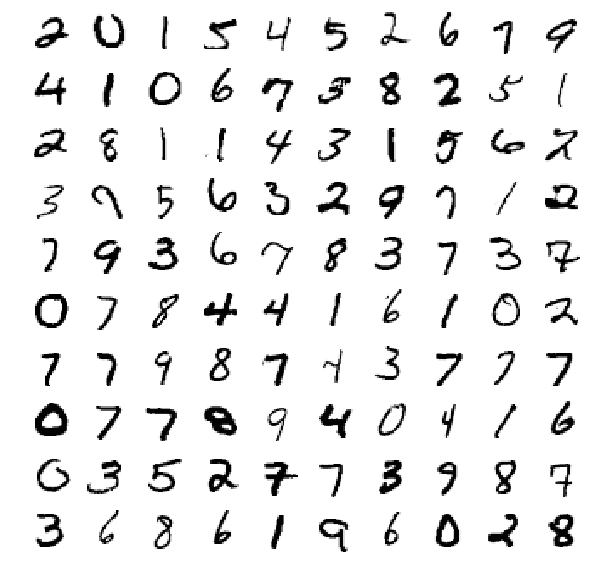

In [5]:
plot_rows = np.random.randint(x_train.shape[0], size=100)
show_num_tf(plot_rows)

# one-vs-all Logistic Regression

We will use regularized one-vs-all logistic regression for trainnig our model. One-vs-all is similar to classification we did before, except now we are dealing with matrices instead of vectors. 

In [4]:
def add_bias(features):
    
    size = features.shape[0]
    
    new_array = np.c_[np.ones(size), features]
    
    return new_array
    
X_biased = add_bias(x_train)

In [5]:
#config

tf.reset_default_graph()
L1 = 1.0 #regularization parameter
learning_rate = 0.1
training_epochs = 5000
logs_path = os.path.join(os.getcwd(),'board')

In [6]:
sample_n, params_n = np.shape(X_biased)
 

with tf.name_scope('Input'):
    y_ = tf.placeholder(tf.float64, [None, 10], name='y_input')
    X_ = tf.placeholder(tf.float64, [None, params_n], name='x_input')

with tf.name_scope('Weights'):
    W = tf.Variable(np.zeros((params_n,10)), name='weight')

with tf.name_scope('Sigmoid'):
    h_ = tf.sigmoid(tf.matmul(X_,W))

# because we are doing one-vs-all classification, it should be element-wise multiply.
# note that axis=0 is needed. 
with tf.name_scope('Cost_fn'):
    cost = tf.reduce_mean(tf.multiply(-y_,tf.log(h_))-tf.multiply(1-y_,tf.log(1-h_)), 
                         axis=0)+0.5*L1*tf.reduce_mean(tf.square(W[1:,:]), axis=0)
    
    tf.summary.scalar('cost', cost)
    
with tf.name_scope('Train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    
with tf.name_scope('Accuracy'):
    prediction = tf.sigmoid(tf.matmul(X_, W))
    y_pred_pf = tf.greater_equal(prediction, 0.5)
    y_pred_pf_float = tf.cast(y_pred_pf, tf.float64)
    mult_mat = tf.multiply(y_pred_pf_float, y_)
    row_sum = tf.reduce_sum(mult_mat, axis=1)
    accuracy = tf.reduce_mean(row_sum)
    tf.summary.scalar('accuracy', accuracy)

cost_history = []
accuracy_history = []
summ = tf.summary.merge_all()

In [7]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logs_path)
writer.add_graph(sess.graph)

for epoch in range(training_epochs):
    sess.run(optimizer, feed_dict={X_:X_biased, y_:y_train})
    cost_value = sess.run(cost, feed_dict={X_:X_biased, y_:y_train})
    acrcy_value = sess.run(accuracy, feed_dict={X_:X_biased, y_:y_train})
    cost_history.append(cost_value)
    accuracy_history.append(acrcy_value)
    

weights = sess.run(W)
sess.close()

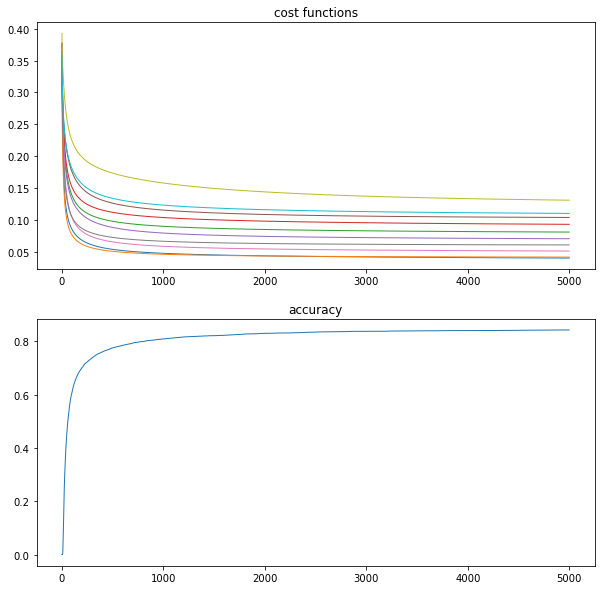

In [8]:
fig, ax = plt.subplots(figsize=(10,10))

plt.xlabel('iterations',fontsize=16)
plt.ylabel('Error', fontsize=16)

plt.subplot(2,1,1)
plt.title('cost functions')
plt.plot(range(training_epochs), cost_history, linewidth=1)
plt.subplot(2,1,2)
plt.title('accuracy')
plt.axis([0,5000,0.1,1])
plt.grid(True)
plt.plot(range(training_epochs), accuracy_history, linewidth=1)

plt.show()

### Accuracy is only around 80%, which is not impressive. Let's test on some of the data that we kept out during training.

In [11]:
def show_num_tf_test(rows, weight):
    
    test_nums = np.empty(25)
    
    fig, ax = plt.subplots(figsize=(5,5))
    
    j = 0
    for row in rows:
        j+=1
        plt.subplot(5,5,j)
        vect_mat = np.reshape(x_test[row,:], (28,28))
        plt.imshow(vect_mat, cmap='Greys')
        plt.axis('off')
    plt.show()
    
    vect1 = add_bias(x_test[rows,:])
    prediction = scipy.special.expit(np.matmul(vect1,weight))
    y_pred_pf = np.greater_equal(prediction, 0.5)
    y_pred = np.matmul(y_pred_pf, 
                      np.array([[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]))
    print(np.reshape(y_pred, [5,5]))

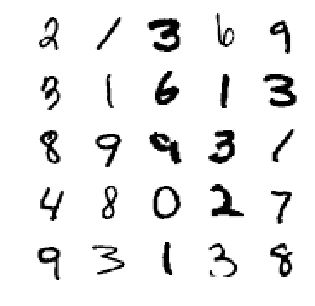

[[ 2  1 11  6  9]
 [ 9  1  6  1  3]
 [ 8  9  0  3  1]
 [ 4  8  0  2  7]
 [ 9  3  1  3  8]]


In [12]:
plot_rows = np.random.randint(x_test.shape[0], size=25)
show_num_tf_test(plot_rows, weights)

In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'CPU']
print(get_available_gpus())

# Back Propagation with TF

I will use backpropagation method to calculate derivative of cost function and feed that to the neural network. 

In [4]:
def add_bias(features):
    
    size = features.shape[0]
    
    new_array = np.c_[np.ones(size), features]
    
    return new_array
    
X_biased = add_bias(x_train)

In [40]:
#config

tf.reset_default_graph()
L1 = 1.0 #regularization parameter
learning_rate = 0.0001
training_epochs = 10000
logs_path = os.path.join(os.getcwd(),'board')

In [56]:
sample_n, params_n = np.shape(X_biased) #Nx785 if images are 28x28 pixles
layer2_n = 25 

with tf.name_scope('Input'):
    y_ = tf.placeholder(tf.float64, [None, 10], name='y_input')
    X_ = tf.placeholder(tf.float64, [None, params_n], name='x_input')

with tf.name_scope('Weights'):
    W1 = tf.Variable(tf.truncated_normal((params_n, layer2_n), dtype=tf.float64), name='W_1')
    W2 = tf.Variable(tf.truncated_normal((layer2_n+1, 10), dtype=tf.float64), name='W_2')

with tf.name_scope('First_Layer'):
    z2 = tf.matmul(X_,W1)
    a2 = tf.sigmoid(z2)
    a2_ = tf.concat([tf.ones([sample_n, 1], tf.float64), a2], axis=1)

with tf.name_scope('Second_Layer'):
    z3 = tf.matmul(a2_,W2)
    h_ = tf.sigmoid(z3)
    

# In NN, we take the mean over entire dataset and entire nodes of the output layer. That's why axis=0 is removed. 
# In one-vs-all classification though, we did minimize each column of the cost function matrix.

with tf.name_scope('Cost_fn'):
    cost = tf.reduce_mean(tf.multiply(-y_,tf.log(h_))-
                          tf.multiply(1-y_,tf.log(1-h_)))
    # +0.5*L1/sample_n*tf.reduce_sum(tf.square(W1[1:,:])+tf.square(W2[1:,:]))
    
    tf.summary.scalar('cost', cost)


def d_sig(z):
    return tf.multiply(tf.sigmoid(z), 1-tf.sigmoid(z))

with tf.name_scope('Back_Prop'):
    delta3 = tf.multiply(h_-y_, d_sig(z3))
    delta2 = tf.multiply(tf.matmul(delta3, tf.transpose(W2[1:,:])), d_sig(z2))
    dJ_W2 = tf.matmul(tf.transpose(a2_), delta3)
    dJ_W1 = tf.matmul(tf.transpose(X_), delta2)


with tf.name_scope('Updating'):    
    update = [tf.assign(W1, tf.subtract(W1,learning_rate*dJ_W1)),
             tf.assign(W2, tf.subtract(W2,learning_rate*dJ_W2))]

with tf.name_scope('Train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    
with tf.name_scope('Accuracy'):
    y_pred_pf = tf.equal(tf.argmax(h_,1), tf.argmax(y_,1))
    y_pred_pf_float = tf.cast(y_pred_pf, tf.float64)
    accuracy = tf.reduce_mean(y_pred_pf_float)
    tf.summary.scalar('accuracy', accuracy)

cost_history = []
accuracy_history = []
summ = tf.summary.merge_all()

In [42]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logs_path)
writer.add_graph(sess.graph)

for epoch in range(training_epochs):
    sess.run(update, feed_dict={X_:X_biased, y_:y_train})
    cost_value = sess.run(cost, feed_dict={X_:X_biased, y_:y_train})
    acrcy_value = sess.run(accuracy, feed_dict={X_:X_biased, y_:y_train})
    cost_history.append(cost_value)
    accuracy_history.append(acrcy_value)


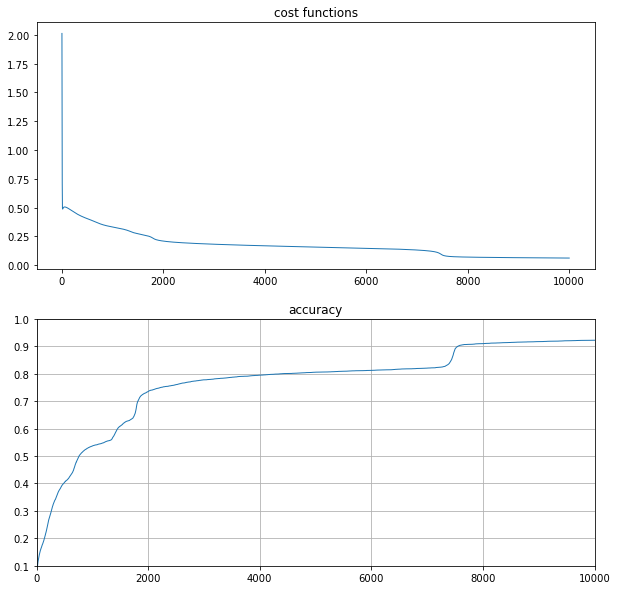

In [45]:
fig, ax = plt.subplots(figsize=(10,10))

plt.xlabel('iterations',fontsize=16)
plt.ylabel('Error', fontsize=16)

plt.subplot(2,1,1)
plt.title('cost functions')
plt.plot(range(training_epochs), cost_history, linewidth=1)
plt.subplot(2,1,2)
plt.title('accuracy')
plt.axis([0,10000,0.1,1])
plt.grid(True)
plt.plot(range(training_epochs), accuracy_history, linewidth=1)

plt.show()